## Word-Level Generative Model

 

In [1]:
import math
import numpy as np
from numpy.random import shuffle, seed, choice
from tqdm import tqdm
from collections import defaultdict, Counter
import pandas as pd
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split,Dataset,DataLoader
from torchvision import datasets, transforms
from torch import nn, optim

import torchvision.transforms as T

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

/Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/canerozer/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 56.0.0 or later, but libpng16.16.dylib provides version 54.0.0'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg

nltk.download('punkt')

text_sentences0 = gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/canerozer/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /Users/canerozer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def bracket_sentence(sent):
    return ['<s>']+sent +['</s>']

text_sentences0=list(map(bracket_sentence, text_sentences0))

In [4]:
text_sentences=[line for line in text_sentences0 if len(line)<100]#100 can be changed if the text string is too big

print(f"total number of words is {sum([len(line) for line in text_sentences])}")

total number of words is 97281


In [5]:
text_string=""

for sent in text_sentences:
    text_string= text_string + " " + " ".join(sent)
    
text_string = text_string[1:]

In [6]:
len(text_string)

469609

In [7]:
text_string=re.sub("'ve"," have",text_string)
text_string=re.sub("n't"," not",text_string)
text_string=re.sub("'ll"," will",text_string)
text_string=re.sub("'m"," will",text_string)
text_string=re.sub("'d"," would",text_string)
text_string=re.sub("'re"," are",text_string)

In [8]:
text_string=re.sub(r'Chapter \d+','', text_string)
text_string=re.sub(r'\[.*?\]','', text_string)
text_string=re.sub(r'[&(;:`)]','', text_string)
text_string=re.sub(r'[\[\]]','', text_string)
#text_string=re.sub(r"\'",'', text_string)
text_string=re.sub(r'"','', text_string)
text_string=re.sub(r'-','', text_string)

text_string=re.sub(r'   ',' ', text_string)
text_string=re.sub(r'  ',' ', text_string)

text_string=re.sub(r'<s>\s*</s>', '', text_string)

In [9]:
text_string = text_string[1:]
text_string=text_string.lower()

In [10]:
text_string[:1000]

" <s> this was the page at which the favourite volume always opened </s> <s> elliot of kellynch hall . </s> <s> walter elliot , born march 1 , 1760 , married , july 15 , 1784 , elizabeth , daughter of james stevenson , esq . </s> <s> of south park , in the county of gloucester , by which lady who died 1800 he has issue elizabeth , born june 1 , 1785 anne , born august 9 , 1787 a still born son , november 5 , 1789 mary , born november 20 , 1791 . </s> <s> precisely such had the paragraph originally stood from the printer ' s hands but sir walter had improved it by adding , for the information of himself and his family , these words , after the date of mary ' s birth married , december 16 , 1810 , charles , son and heir of charles musgrove , esq . </s> <s> of uppercross , in the county of somerset , and by inserting most accurately the day of the month on which he had lost his wife . </s> <s> heir presumptive , william walter elliot , esq ., great grandson of the second sir walter . </s>

In [11]:
print(f"The number of characters in the text is {len(text_string)}")

The number of characters in the text is 463040


In [12]:
text_sentences1=re.split(' ', text_string)
text_sentences1 = [item for item in text_sentences1 if item.strip()]

text_sentences1[:100]




['<s>',
 'this',
 'was',
 'the',
 'page',
 'at',
 'which',
 'the',
 'favourite',
 'volume',
 'always',
 'opened',
 '</s>',
 '<s>',
 'elliot',
 'of',
 'kellynch',
 'hall',
 '.',
 '</s>',
 '<s>',
 'walter',
 'elliot',
 ',',
 'born',
 'march',
 '1',
 ',',
 '1760',
 ',',
 'married',
 ',',
 'july',
 '15',
 ',',
 '1784',
 ',',
 'elizabeth',
 ',',
 'daughter',
 'of',
 'james',
 'stevenson',
 ',',
 'esq',
 '.',
 '</s>',
 '<s>',
 'of',
 'south',
 'park',
 ',',
 'in',
 'the',
 'county',
 'of',
 'gloucester',
 ',',
 'by',
 'which',
 'lady',
 'who',
 'died',
 '1800',
 'he',
 'has',
 'issue',
 'elizabeth',
 ',',
 'born',
 'june',
 '1',
 ',',
 '1785',
 'anne',
 ',',
 'born',
 'august',
 '9',
 ',',
 '1787',
 'a',
 'still',
 'born',
 'son',
 ',',
 'november',
 '5',
 ',',
 '1789',
 'mary',
 ',',
 'born',
 'november',
 '20',
 ',',
 '1791',
 '.',
 '</s>',
 '<s>']

In [13]:
len(text_sentences1)

94615

In [14]:
#YOU CAN CUT INTO HALF FOR FASTER TRAINING. 47310 is a specific index that cuts the text from end of a sentence

In [15]:
text_sentences1=text_sentences1[:47310]

In [16]:
len(text_sentences1)

47310

In [17]:
vocabulary = sorted(set(text_sentences1)) 

vocabulary_size = len(vocabulary)
vocabulary[:100]

['!',
 "!'",
 "'",
 "'.",
 ',',
 ",'",
 '.',
 ".'",
 '.,',
 '1',
 '15',
 '16',
 '1760',
 '1784',
 '1785',
 '1787',
 '1789',
 '1791',
 '1800',
 '1806',
 '1810',
 '1814',
 '20',
 '29th',
 '5',
 '9',
 '</s>',
 '<s>',
 '?',
 "?'",
 'a',
 'abbreviation',
 'abilities',
 'able',
 'abode',
 'abominates',
 'about',
 'above',
 'abroad',
 'absence',
 'absent',
 'absenting',
 'absolutely',
 'abstraction',
 'absurd',
 'abundance',
 'abused',
 'accept',
 'acceptable',
 'accepted',
 'accepting',
 'accession',
 'accident',
 'accommodate',
 'accommodating',
 'accommodations',
 'accompany',
 'accompanying',
 'accomplish',
 'accomplishments',
 'accordingly',
 'account',
 'accounts',
 'accurately',
 'accuse',
 'accustomary',
 'acknowledge',
 'acknowledged',
 'acquaintance',
 'acquainted',
 'acquiescence',
 'acquired',
 'acquittal',
 'acre',
 'acres',
 'across',
 'act',
 'acted',
 'acting',
 'action',
 'active',
 'actual',
 'actually',
 'actuated',
 'acute',
 'adapted',
 'add',
 'added',
 'adding',
 'addit

In [18]:
vocabulary_size

3922

In [19]:
word2ind=dict()

for key in vocabulary:
    word2ind[key]= vocabulary.index(key)

In [20]:
word2ind

{'!': 0,
 "!'": 1,
 "'": 2,
 "'.": 3,
 ',': 4,
 ",'": 5,
 '.': 6,
 ".'": 7,
 '.,': 8,
 '1': 9,
 '15': 10,
 '16': 11,
 '1760': 12,
 '1784': 13,
 '1785': 14,
 '1787': 15,
 '1789': 16,
 '1791': 17,
 '1800': 18,
 '1806': 19,
 '1810': 20,
 '1814': 21,
 '20': 22,
 '29th': 23,
 '5': 24,
 '9': 25,
 '</s>': 26,
 '<s>': 27,
 '?': 28,
 "?'": 29,
 'a': 30,
 'abbreviation': 31,
 'abilities': 32,
 'able': 33,
 'abode': 34,
 'abominates': 35,
 'about': 36,
 'above': 37,
 'abroad': 38,
 'absence': 39,
 'absent': 40,
 'absenting': 41,
 'absolutely': 42,
 'abstraction': 43,
 'absurd': 44,
 'abundance': 45,
 'abused': 46,
 'accept': 47,
 'acceptable': 48,
 'accepted': 49,
 'accepting': 50,
 'accession': 51,
 'accident': 52,
 'accommodate': 53,
 'accommodating': 54,
 'accommodations': 55,
 'accompany': 56,
 'accompanying': 57,
 'accomplish': 58,
 'accomplishments': 59,
 'accordingly': 60,
 'account': 61,
 'accounts': 62,
 'accurately': 63,
 'accuse': 64,
 'accustomary': 65,
 'acknowledge': 66,
 'acknowled

In [21]:
encoded_text_sentences1=[word2ind[key] for key in text_sentences1]

In [22]:
sample_len=51

input_seq_words = []
target_seq_words = []

for k in range(len(encoded_text_sentences1)-sample_len+1):

    # Remove last word for input sequence
    input_seq_words.append(encoded_text_sentences1[k:k+sample_len-1])

    # Remove firsts word for target sequence
    target_seq_words.append(encoded_text_sentences1[k+1:k+sample_len])

In [23]:
def int2OneHot(X,size):

    def int2OneHot1(x,size=10):
        tmp = np.zeros(size)
        tmp[int(x)] = 1.0
        return tmp

    return np.array([ int2OneHot1(x, size) for x in X ]).astype('double')


def seq2OneHot(seq,size):
    return np.array([ int2OneHot(x, size) for x in seq ])

In [24]:
len(input_seq_words[0])

50

In [25]:
input_seq_words[0]

[27,
 3527,
 3791,
 3505,
 2446,
 314,
 3825,
 3505,
 1358,
 3764,
 183,
 2398,
 26,
 27,
 1154,
 2374,
 1959,
 1620,
 6,
 26,
 27,
 3779,
 1154,
 4,
 472,
 2126,
 9,
 4,
 12,
 4,
 2133,
 4,
 1944,
 10,
 4,
 13,
 4,
 1153,
 4,
 895,
 2374,
 1925,
 3337,
 4,
 1221,
 6,
 26,
 27,
 2374,
 3268]

In [26]:
target_seq_words[0]

[3527,
 3791,
 3505,
 2446,
 314,
 3825,
 3505,
 1358,
 3764,
 183,
 2398,
 26,
 27,
 1154,
 2374,
 1959,
 1620,
 6,
 26,
 27,
 3779,
 1154,
 4,
 472,
 2126,
 9,
 4,
 12,
 4,
 2133,
 4,
 1944,
 10,
 4,
 13,
 4,
 1153,
 4,
 895,
 2374,
 1925,
 3337,
 4,
 1221,
 6,
 26,
 27,
 2374,
 3268,
 2465]

In [27]:
input_seq = torch.Tensor(input_seq_words).type(torch.long)
target_seq = torch.Tensor(target_seq_words).type(torch.long)

In [28]:
class Basic_Dataset(Dataset):

    def __init__(self, X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    # return a pair x,y at the index idx in the data set
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

ds = Basic_Dataset(input_seq,target_seq)

In [29]:
batch_size = 128 

data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)



In [30]:
embedding_dimension=200

weights_matrix= np.zeros((vocabulary_size, embedding_dimension))

with open("/Users/canerozer/Desktop/HW05/glove.6B/glove.6B.200d.txt", 'r', encoding='utf-8') as f: 
    
    for line in f:
        values=line.split()
        word=values[0]
        vector=np.asarray(values[1:], "float32")
        if word in word2ind:
            index = word2ind[word]
            weights_matrix[index]= vector
            
            
weights_matrix=torch.tensor(weights_matrix, dtype=torch.float)




In [31]:
class WordGen_Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, embedding_weights, hidden_dim):
        super(WordGen_Model, self).__init__()
        
        self.vocabulary_size=vocabulary_size
        self.embedding_size=embedding_size
        self.hidden_dim=hidden_dim
        
        self.embedding= nn.Embedding(self.vocabulary_size, self.embedding_size)
        self.embedding.weight= nn.Parameter(embedding_weights)
        self.embedding.weight.requires_grad= True
        
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_dim, batch_first=True)
        
        self.linear= nn.Linear(self.hidden_dim, self.vocabulary_size)

        
    def forward(self, x):
        
        x=self.embedding(x)
        
        lstm_out, _ = self.lstm(x)
        
        lstm_out= lstm_out.contiguous().view(-1, self.hidden_dim)
        
        output=self.linear(lstm_out)
        
        output=output.view(x.shape[0], x.shape[1], self.vocabulary_size)
        
        return output
        
        


In [32]:
hidden_dimension=256

model=WordGen_Model(vocabulary_size, embedding_dimension, weights_matrix, hidden_dimension)


In [33]:
num_epochs=5


optimizer=torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

loss_fn= nn.CrossEntropyLoss()

losses=[]


for epoch in tqdm(range(num_epochs)):
    
    model.train()
    
    for X_train_batch, Y_train_batch in data_loader:
        
        optimizer.zero_grad()
        Y_train_hat=model(X_train_batch)
        
        loss=loss_fn(Y_train_hat.view(-1, vocabulary_size), Y_train_batch.view(-1))
        loss.backward()
        optimizer.step()
    
    losses.append(loss.item())



100%|████████████████████████████████████████████| 5/5 [26:53<00:00, 322.61s/it]


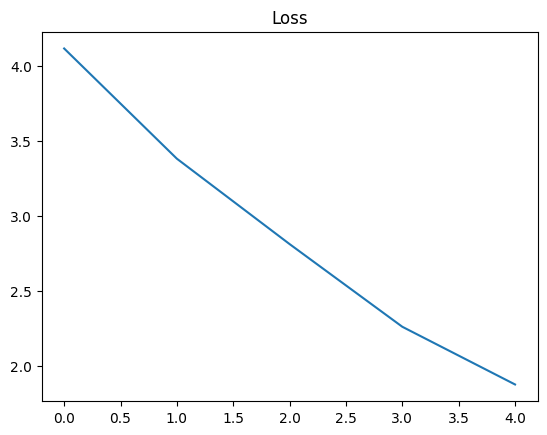

In [34]:
plt.title('Loss')
plt.plot(losses)

In [67]:
def softmax_with_temperature(vec, temperature):
    sum_exp = sum(math.exp(x/temperature) for x in vec)
    return [math.exp(x/temperature)/sum_exp for x in vec]

In [101]:
end_tag=26 #end tag encoded index

max_len=30

num_sentences=10

for i in range(num_sentences):

    num=0
    preds=[27] #start tag encoded index

    while num !=  max_len and preds[-1]!=end_tag:

        output=model(torch.Tensor([preds]).type(torch.long))
    
        p=softmax_with_temperature(output[0][-1], 0.3)
    
        est=choice(list(range(3922)), p=p)
    
        preds += [est]
    
        num +=1

    print(' '.join([vocabulary[i] for i in preds]))
    print('\n')
    

<s> if i am sure , i am sure , i am sure , i am not like a great deal of it . </s>


<s> i am sure you will not like him . </s>


<s> she was a very good spirits , which she had been anxiously giving her in marking out the ships that captain wentworth had been a considerable appearance of attachment previous


<s> she had a little while i always cure you , i have not seen him . </s>


<s> i am sure , i am sure , i shall be very much better than you to have to give him a word , i am sure , i am


<s> i am sure , said she , i am sure , i am very angry with you , i am sure , i am sure , i am sure ,


<s> she had the satisfaction of finding an opinion of her own , had been to fanny harville ' s , and were now altogether but she was to join them


<s> she had a cultivated mind , and she had no reason to suppose it was the same immediate association of it , and the fainter self threatenings of the past


<s> i am sure , i am sure , i am sure , i am sure , i am sure you will not like him . </